In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional,\
                      GRU, Dropout, GlobalAveragePooling1D, Conv1D, TimeDistributed
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam
from tqdm.keras import TqdmCallback
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import re
from nltk import sent_tokenize, word_tokenize, pos_tag, ne_chunk
import nltk.data
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktTrainer
import pickle
import math
#import collections.Iterable as Iterable

import sklearn.metrics as metrics
import matplotlib.pyplot as plt

import gzip
from lxml import etree
from tqdm import tqdm
import random

%load_ext autoreload
%autoreload 2
import os, inspect, sys
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
from unwiki import unwiki
import ner
from embed_utils import open_w2v
import clean_and_token_text as clean

In [2]:
#with open('/media/hd1/wikipedia/wiki_definitions_improved.txt', 'r') as wiki_f:
#    wiki = wiki_f.readlines()

cfg = {}

wiki = []
with gzip.open('/media/hd1/wikipedia/wiki_definitions_improved.xml.gz', 'r') as xml_fobj:
    def_xml = etree.parse(xml_fobj)
    for art in def_xml.findall('definition'):
        data = (art.find('.//dfndum').text, '', art.find('.//stmnt').text)
        wiki.append(data)

# Get data and train the Sentence tokenizer
# Uses a standard algorithm (Kiss-Strunk) for unsupervised sentence boundary detection
text = ''
for i in range(3550):
    text += wiki[i][2]

trainer = PunktTrainer()
trainer.INCLUDE_ALL_COLLOCS = True
trainer.train(text)
sent_tok = PunktSentenceTokenizer(trainer.get_params())
print(sent_tok._params.abbrev_types)

def_lst = ner.bio_tag.put_pos_ner_tags(wiki, sent_tok)

{'w.b', 'ye', 'a.i', 'cf', 'j.m', 'a.d', 'crinem', 'happiness', 'eng', 'a.s', 'p.m', 'rum', 'sas', 'aff', 'ie', 'rv', 'gta', 'f.h', 'i.e', 'pl', 's1', 'c6an', 'viz', 'p.o.a', 'm4', 'fins', 'u.s', '1949.03631mm', 'i.i.d', '2a', 'u.s.c', 'p.h.d', 'j.c', 'jr', 'qom', 'etc', "'up", "'if", 'i.d', 'gov', 'j.d', 'd1', 'pdi', 'technician', 'subpopulation', 'ts2', '15b', 'r/m', 'ifc', 'nfa', 'np5', 'e.g', 'ltd', 's.c', 'hrc', 'n.b', 'g.i', 'nsb', '|c|', 'dha', 'z-1', 'o.s.m', 'j.w', 'q.v', 'pt', 'b.k.s', 'exhibition', 'resp', 'm.n', 'x+2', 'anomalies', 'vs', 'p.12', 'fn', 'a.k.a', 'orb', 'tov', 'spacewalks', 'ph.d', 's.r', 'juniper', 'c.w', 's.p.r.l', 'u.n', 'm-m', 'ed', 'jie', 'i.w.w', 'fig', 'al', 'acb', 'oct', 's.t', 'sow', 'r.a', 'rim', 'exe', 'c.s', 'az', 's^2', 'k.c', 'soc', 'ginebra', 'b-1'}


In [3]:
#cf = {'input_dim': len(word_tok.word_index)+1,
#      'output_dim': 25,
#     'input_length': max([len(l) for l in fields['tokens']])//12,
#     'n_tags': 4,
#     'batch_size': 1000}    


# Define the categorical labels
#train_lab2_cat = np.array([to_categorical(c, num_classes=cf['n_tags']) for c in train_lab2])
#embed_matrix = np.zeros((cf['input_dim'], 200))
#coverage_cnt = 0
#coverage_lst = []
with open_w2v('/media/hd1/embeddings/model4ner_19-33_02-01/vectors.bin') as embed_dict:
    wind = ['<UNK>',] + list(embed_dict.keys())
    cfg['emb_nvocab'] = len(wind) 
    embed_matrix = np.zeros((cfg['emb_nvocab'], 200))
    for word, vec in embed_dict.items():
        #vect = embed_dict.get(word)
        ind = wind.index(word)
            #vect = vect/np.linalg.norm(vect)
        embed_matrix[ind] = vec
#print("Coverage of embed is: {}".format(coverage_cnt/len(embed_dict)))

Vocabulary size: 208442 and dimension of embed: 200


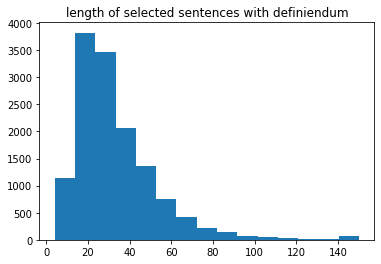

In [4]:
sent_lengths = []
for d in def_lst:
    slen = min(len(d['ner']), 150)
    sent_lengths.append(slen)
plt.hist(sent_lengths, bins=15)
plt.title('length of selected sentences with definiendum')
plt.show()

In [5]:
cfg['padseq'] = {'maxlen': 50 , 'padding': 'post', 'truncating': 'post'}
cfg['n_tags'] = 2

# shuffle def_lst
random.shuffle(def_lst)

cfg['train_test_split'] = 0.8

train_def_lst = def_lst[:int(cfg['train_test_split']*len(def_lst))]
test_def_lst = def_lst[int(cfg['train_test_split']*len(def_lst)):]

def prep_data(dat, wind, cfg, *args):
    '''
   dat should be in the "ner" format
    '''
    if isinstance(dat, str):
        dat_tok = word_tokenize(dat)
        norm_words = [clean.normalize_text(d).strip() for d in dat_tok]
        labels = [False for d in dat]
    else:
        norm_words = [clean.normalize_text(d[0][0]).strip() for d in dat]
        labels = [d[1] != 'O' for d in dat]
    ind_words = []
    for w in norm_words:
        try:
            ind_words.append(wind.index(w))
        except ValueError:
            ind_words.append(0)
    #ind_words = pad_sequences([ind_words], **cfg['padseq'])
    #labels  = pad_sequences([labels], **cfg['padseq'])
    #labels  = to_categorical(labels, num_classes=cfg['n_tags'])
    return ind_words, labels

train_data = [prep_data(d['ner'], wind, cfg) for d in train_def_lst]
train_seq, train_lab = zip(*train_data)
train_seq = pad_sequences(train_seq, **cfg['padseq'])
train_lab = pad_sequences(train_lab, **cfg['padseq'])
#train_lab = np.array([to_categorical(s, num_classes=cfg['n_tags']) for s in train_lab])

test_data = [prep_data(d['ner'], wind, cfg) for d in test_def_lst]
test_seq, test_lab = zip(*test_data)
test_seq = pad_sequences(test_seq, **cfg['padseq'])
test_lab = pad_sequences(test_lab, **cfg['padseq'])
#test_lab = np.array([to_categorical(s, num_classes=cfg['n_tags']) for s in test_lab])

### TODO
* protect _inline_math_ from keras tokenizer, right now it is breaking it up
* Search for a minimal stemmer that strips plural or adverbial suffices for example zero-sum games in zero-sum game or absolute continuity and absolute continuous

In [32]:
%%script echo this is a goner
cfg = {'oov_token': '<UNK>', }

tok_set = set()
for d in def_lst:
    

word_tok = Tokenizer(oov_token='<UNK>')
clean_str = lambda s: unwiki.loads(eval(s)).replace('\n', ' ')
fields = {'texts': [], 'titles': [], }
for w in wiki:
    title, section, defin_parag = w.split('-#-%-')
    defin_parag = clean_str(defin_parag)
    for defin in sent_tok.tokenize(defin_parag):
        fields['titles'].append(title.lower().strip())
        fields['texts'].append(defin)
word_tok.fit_on_texts(fields['titles'] + fields['texts'])

rev_word_index = (1 + len(word_tok.word_index))*['***']
for word,ind in word_tok.word_index.items():
    rev_word_index[ind] = word

In [33]:
fields['texts'][1683]

'Despite this, unions were formed and began to acquire political power, eventually resulting in a body of labour law that not only legalized organizing efforts, but codified the relationship between employers and those employees organized into unions.'

In [34]:
%%script echo this is a goner
fields['labels'] = []
fields['tokens'] = word_tok.texts_to_sequences(fields['texts'])
empty_sentence_lst = []
for N in range(len(fields['texts'])):
    title_lst = word_tok.texts_to_sequences([fields['titles'][N].strip()])[0]
    tags = ner.bio_tag.bio_tkn_tagger(title_lst, fields['tokens'][N] )
    try:
        fields['labels'].append(list(zip(*tags))[1])
    except IndexError:
        fields['labels'].append(['0'])
        empty_sentence_lst.append(N)
print(f'Found {len(empty_sentence_lst)} empty sentences')

Found 59 empty sentences


In [43]:
%%script echo this is a goner
K = 31765
Tex = fields['texts'][K]
Tok = fields['tokens'][K]
Lab = fields['labels'][K]
Tit = fields['titles'][K]
print(f'the title of the article is: {Tit}')
for ind, t in enumerate(Tok):
    print('{0:>5} {1:>12} {2:>5}'.format(t, rev_word_index[t], Lab[ind]))

this is a goner


In [86]:
%%script echo This is a goner
cfg['maxlen'] = 50 #max([len(l) for l in fields['tokens']])//12
cfg['padding'] = 'post'
train_seq = pad_sequences(fields['tokens'], maxlen=cfg['maxlen'], padding=cfg['padding'])
train_lab = pad_sequences(fields['labels'], maxlen=cfg['maxlen'], padding=cfg['padding'])
train_seq2 = []
train_lab2 = []
for ind, t in enumerate(train_lab):
    if 2 in t:
        train_seq2.append(train_seq[ind])
        train_lab2.append(train_lab[ind])
train_seq2 = np.array(train_seq2)
train_lab2 = np.array(train_lab2)

This is a goner


In [37]:
class NerModel(tf.keras.Model):
    def __init__(self, hidden_num, vocab_size, label_size, embedding_size):
        super(NerModel, self).__init__()
        self.hidden_num = hidden_num
        self.vocab_size = vocab_size
        self.label_size = label_size
        
        self.embedding = Embedding(vocab_size, embedding_size)
        self.biLSTM = Bidirectional(LSTM(hidden_num, return_sequences=True))
        self.dropout = tf.keras.layers.Dropout(0.2)
        self.dense = Dense(label_size)
        
        self.transition_params = tf.Variable(tf.random.uniform(shape=(label_size, label_size)))
        
    def call(self, text, labels=None, training=None):
        text_lens = tf.math.reduce_sum(tf.cast(tf.math.not_equal(text, 0), dtype=tf.int32), axis=-1)
        inputs = self.embedding(text)
        inputs = self.biLSTM(inputs)
        inputs = self.dropout(inputs, training)
        logits = self.dense(inputs)
        
        if labels is not None:
            label_sequences = tf.convert_to_tensor(labels, dtype=tf.int32)
            log_likelihood, self.transition_params = \
            tfa.text.crf_log_likelihood(logits, label_sequences, text_lens,
                                        transition_params=self.transition_params)
            return logits, text_lens, log_likelihood
        else:
            return logits, text_lens
        
#model.summary()

In [38]:
# Train NER model
cfg['learning_rate'] = 0.1
model = NerModel(64, len(word_tok.word_index)+1, 4, 100)
optimizer = tf.keras.optimizers.Adam()
def train_one_step(text_batch, labels_batch):
    with tf.GradientTape() as tape:
        logits, text_lens, log_likelihood = model(text_batch, labels_batch, training=True)
        loss = - tf.reduce_mean(log_likelihood)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, logits, text_lens

def get_acc_one_step(logits, text_lens, labels_batch):
    paths = []
    accuracy = 0
    for logit, text_len, labels in zip(logits, text_lens, labels_batch):
        viterbi_path, _ = tfa.text.viterbi_decode(logit[:text_len], model.transition_params)
        paths.append(viterbi_path)
        correct_prediction = tf.equal(
            tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences([viterbi_path],
                                                            padding='post'), dtype=tf.int32),
            tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences([labels[:text_len]],
                                                            padding='post'), dtype=tf.int32)
        )
        accuracy = accuracy + tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        # print(tf.reduce_mean(tf.cast(correct_prediction, tf.float32)))
    accuracy = accuracy / len(paths)
    return accuracy

best_acc = 0
step = 0
epochs = 20
bs = 1000
for epoch in range(epochs):
    for (text_batch, labels_batch) in \
    [[train_seq2[bs*i:bs*(i+1)], train_lab2[bs*i:bs*(i+1)]]\
     for i in range(math.ceil(len(train_seq2)/bs))]:
        step = step + 1
        loss, logits, text_lens = train_one_step(text_batch, labels_batch)
        if step % 20 == 0:
            accuracy = get_acc_one_step(logits, text_lens, labels_batch)
            print('epoch %d, step %d, loss %.4f , accuracy %.4f' % (epoch, step, loss, accuracy))
            if accuracy > best_acc:
                best_acc = accuracy
                #ckpt_manager.save()
                print("model saved")

Instructions for updating:
Use tf.identity instead.
epoch 1, step 20, loss 14.9342 , accuracy 0.8911
model saved
epoch 3, step 40, loss 7.0272 , accuracy 0.9495
model saved
epoch 5, step 60, loss 5.6116 , accuracy 0.9628
model saved
epoch 7, step 80, loss 4.2118 , accuracy 0.9717
model saved
epoch 9, step 100, loss 4.0879 , accuracy 0.9750
model saved
epoch 10, step 120, loss 4.2285 , accuracy 0.9665
epoch 12, step 140, loss 3.8653 , accuracy 0.9675
epoch 14, step 160, loss 3.1836 , accuracy 0.9706
epoch 16, step 180, loss 3.0588 , accuracy 0.9720
epoch 18, step 200, loss 2.4088 , accuracy 0.9749
epoch 19, step 220, loss 2.1086 , accuracy 0.9771
model saved


In [39]:
model.summary()

Model: "ner_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  4208400   
_________________________________________________________________
bidirectional (Bidirectional multiple                  84480     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  516       
Total params: 4,293,412
Trainable params: 4,293,412
Non-trainable params: 0
_________________________________________________________________


In [8]:
sample_str = 'A banach space is defined as named entity recognition'
sample_tok = word_tok.texts_to_sequences([sample_str])
sample_pad = pad_sequences(sample_tok, maxlen=cfg['maxlen'], padding=cfg['padding'])
pred = [model.predict(text_batch[i])[1] for i in range(len(text_batch))]

NameError: name 'word_tok' is not defined

In [6]:
cfg.update({'input_dim': len(wind),
      'output_dim': 200,
     'input_length': cfg['padseq']['maxlen'],
     'n_tags': 2,
     'batch_size': 1000,
      'adam': {'lr': 0.05, 'beta_1': 0.9, 'beta_2': 0.999}})

In [7]:
# DEFINE MODEL WITH biLSTM AND TRAIN FUNCTION    
def get_bilstm_lstm_model(cfg_dict):
    model = Sequential()
    # Add Embedding layer
    model.add(Embedding(cfg_dict['input_dim'], 
                        output_dim=cfg_dict['output_dim'],
                        input_length=cfg_dict['input_length'],
                       weights = [embed_matrix],
                       trainable = False))
    #model.add(Embedding(cfg_dict['input_dim'], 
    #                    output_dim=cfg_dict['output_dim'],
    #                    input_length=cfg_dict['input_length']))
    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=cfg_dict['output_dim'],
                                 return_sequences=True,
                                 dropout=0.2, 
                                 recurrent_dropout=0.2), merge_mode = 'concat'))
    # Add LSTM
    model.add(LSTM(units=cfg_dict['output_dim'],
                   return_sequences=True, dropout=0.2, recurrent_dropout=0.2,
                   recurrent_initializer='glorot_uniform'))
    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(1, activation="sigmoid")))
    #Optimiser 
    adam = Adam(**cfg['adam'])
    # Compile model
    #bce = tf.keras.losses.BinaryCrossentropy(sample_weight=[0.3, 0.7])
    model.compile(loss = 'binary_crossentropy',
                  optimizer=adam, metrics=['accuracy'])
    model.summary()
    
    return model

def train_model(X, y, model, epochs=10):
    # fit model for one epoch on this sequence
    res = model.fit(X, y, verbose=0, epochs=epochs,
                    batch_size=cfg['batch_size'],
                    validation_data=(test_seq, test_lab),
                   callbacks=[TqdmCallback(verbose=1)])
                   
    return res
model_bilstm_lstm = get_bilstm_lstm_model(cfg)
#plot_model(model_bilstm_lstm)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 200)           41688600  
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 400)           641600    
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 200)           480800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 1)             201       
Total params: 42,811,201
Trainable params: 1,122,601
Non-trainable params: 41,688,600
_________________________________________________________________


In [8]:
history = train_model(train_seq, train_lab, model_bilstm_lstm, epochs=20)

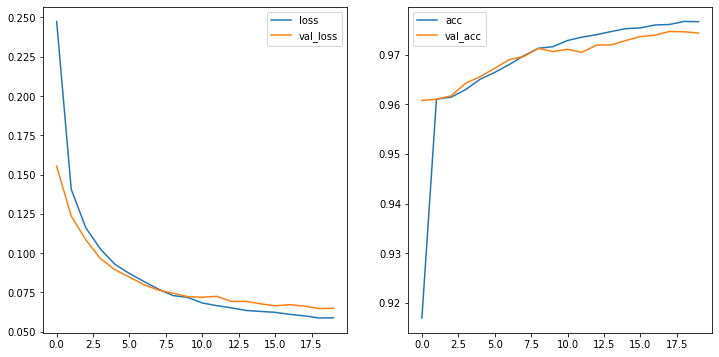

In [9]:
r = history
fig = plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
ax1.plot(r.history['loss'], label='loss')
ax1.plot(r.history['val_loss'], label='val_loss')
ax1.legend()
ax2 = plt.subplot(122)
ax2.plot(r.history['accuracy'], label='acc')
ax2.plot(r.history['val_accuracy'], label='val_acc')
ax2.legend()

In [10]:
#sample_str = 'a banach space is defined as complete vector space of some kind .'
sample_str = 'We define a shushu space as a complete vector space of some kind .'
#sample_str = '_display_math_ The Ursell functions of a single random variable X are obtained from these by setting _inline_math_..._inline_math_ .'
sample_pad, _ = prep_data(sample_str, wind, cfg, 'no_tags')
sample_pad = pad_sequences([sample_pad], **cfg['padseq'])
pred = model_bilstm_lstm.predict(sample_pad)
#np.argmax(pred.squeeze(), axis=1)
for i, w in enumerate(sample_pad[0]):
    if wind[w] == '.':
        break
    print(wind[w], np.round(pred)[0][i])
    if wind[w] == '.':
        break

we [0.]
define [0.]
a [0.]
<UNK> [1.]
space [1.]
as [0.]
a [0.]
complete [0.]
vector [0.]
space [0.]
of [0.]
some [0.]
kind [0.]


In [27]:
preds = model_bilstm_lstm.predict(test_seq)

In [ ]:
# Compute the Loss independently
bce = tf.keras.losses.BinaryCrossentropy()
bce(test_lab, np.squeeze(preds)).numpy()

In [ ]:
tf.keras.losses.A

In [70]:
#1/5404.0*(np.sum(test_lab*np.log(np.squeeze(preds))) + np.sum((1-test_lab)*np.log(np.squeeze(1-preds))))

-1.607125580773316

# get_bilstm_lstm_model Training history
## First working attempt:
Epochs: 70 [01:00<00:00, 3.00s/epoch, loss=0.0513, accuracy=0.98, val_loss=0.0636, val_accuracy=0.975]

commit e4c41f0


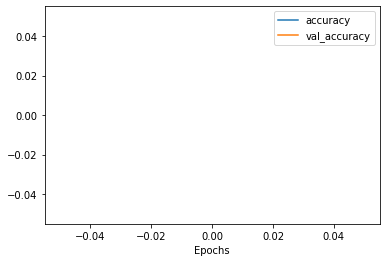

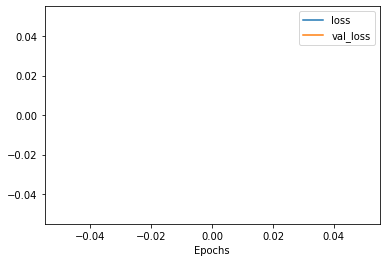

In [47]:
def plot_graphs(history, string, start_at=0):
    plt.plot(history[string][start_at:])
    plt.plot(history['val_'+string][start_at:])
    plt.xlabel('Epochs')
    plt.ylabel(string[start_at:])
    plt.legend([string, 'val_'+string])
    plt.show()
    
plot_graphs(history, "accuracy", start_at=400)
plot_graphs(history, "loss", start_at=400)

In [362]:
wiki[850]

'Indicator function  -#-%-  Definition  -#-%-  "The indicator function of a subset \'\'A\'\' of a set \'\'X\'\' is a function\\n\\n:<math>\\\\mathbf{1}_A \\\\colon X \\\\to \\\\{ 0,1 \\\\} </math>\\n\\ndefined as\\n\\n:<math>\\\\mathbf{1}_A(x) :=\\n\\\\begin{cases}\\n1 &\\\\text{if } x \\\\in A, \\\\\\\\\\n0 &\\\\text{if } x \\\\notin A.\\n\\\\end{cases}\\n</math>\\n\\nThe [[Iverson bracket]] allows the equivalent notation, <math>[x\\\\in A]</math>, to be used instead of <math>\\\\mathbf{1}_A(x)</math>.\\n\\nThe function <math>\\\\mathbf{1}_A</math> is sometimes denoted <math>I_A</math>, <math>\\\\chi_A</math>, \'\'K<sub>A</sub>\'\' or even just <math>A</math>. (The [[Greek alphabet|Greek letter]] <math>\\\\chi</math> appears because it is the initial letter of the Greek word χαρακτήρ, which is the ultimate origin of the word \'\'characteristic\'\'.)\\n\\nThe set of all indicator functions on <math>X</math> can be identified with <math>\\\\mathcal{P}(X)</math>, the [[power set]] of <ma